In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import numpy as np
import requests
import json

In [ ]:
gas_path = '/content/drive/My Drive/Project CS163 Datasets/Monthly Gas Prices.csv'
elec_path = '/content/drive/My Drive/Project CS163 Datasets/California Electric Rates.csv'

In [ ]:
gas_df = pd.read_csv(gas_path, skiprows=2, usecols=[0,1])
# Rename columns to simple names.
gas_df.columns = ['Date', 'Gas Price']
# Inspect the first few rows
print("Gas Data Preview:")
print(gas_df.head())

Gas Data Preview:
       Date  Gas Price
0  May-2000      1.676
1  Jun-2000      1.669
2  Jul-2000      1.754
3  Aug-2000      1.720
4  Sep-2000      1.869


In [ ]:
gas_df = gas_df[gas_df['Date'] != 'Date']
gas_df = gas_df.dropna(subset=['Date'])

In [ ]:
# Convert the 'Date' column to datetime format.
gas_df['Date'] = pd.to_datetime(gas_df['Date'], errors='coerce', format='%b-%Y')
gas_df = gas_df.dropna(subset=['Date'])
# Filter data for years 2000 to 2024.
gas_df = gas_df[(gas_df['Date'].dt.year >= 2000) & (gas_df['Date'].dt.year <= 2024)]
# Create a YearMonth column for merging.
gas_df['YearMonth'] = gas_df['Date'].dt.to_period('M')

In [ ]:
# Process Electric Rates Data
elec_df = pd.read_csv(elec_path)
print("Electric Rates Data Preview:")
print(elec_df.head())

Electric Rates Data Preview:
                Date  Value (USD/kWh)
0   January 31, 1990           0.0804
1  February 28, 1990           0.0846
2     March 31, 1990           0.0840
3     April 30, 1990           0.0818
4       May 31, 1990           0.0858


In [ ]:
if 'YearMonth' in elec_df.columns:
    elec_df = elec_df.drop(columns=['YearMonth'])

In [ ]:
elec_df.loc[:, 'YearMonth'] = pd.to_datetime(elec_df['Date']).dt.to_period('M')

In [ ]:
elec_df.columns = ['Date', 'Electric Rate', 'YearMonth']
# Convert the 'Date' column to datetime.
elec_df['Date'] = pd.to_datetime(elec_df['Date'])
# Filter data for years 2000 to 2024.
elec_df = elec_df[(elec_df['Date'].dt.year >= 2000) & (elec_df['Date'].dt.year <= 2024)]

In [ ]:
# Merge the Two Datasets
# Merge on the YearMonth column.
merged_df = pd.merge(gas_df[['YearMonth', 'Gas Price']],
                     elec_df[['YearMonth', 'Electric Rate']],
                     on='YearMonth')
# Create a Date column for plotting using the YearMonth information.
merged_df['Date'] = merged_df['YearMonth'].dt.to_timestamp()

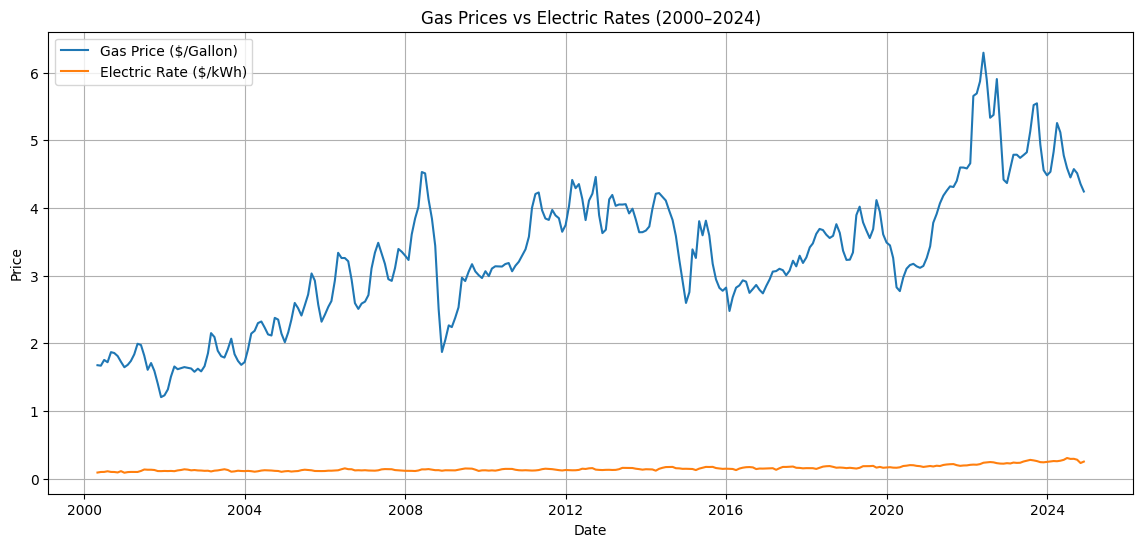

In [ ]:
# Original Prices Plot
plt.figure(figsize=(14, 6))
plt.plot(merged_df['Date'], merged_df['Gas Price'], label='Gas Price ($/Gallon)')
plt.plot(merged_df['Date'], merged_df['Electric Rate'], label='Electric Rate ($/kWh)')
plt.title('Gas Prices vs Electric Rates (2000–2024)')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.show()

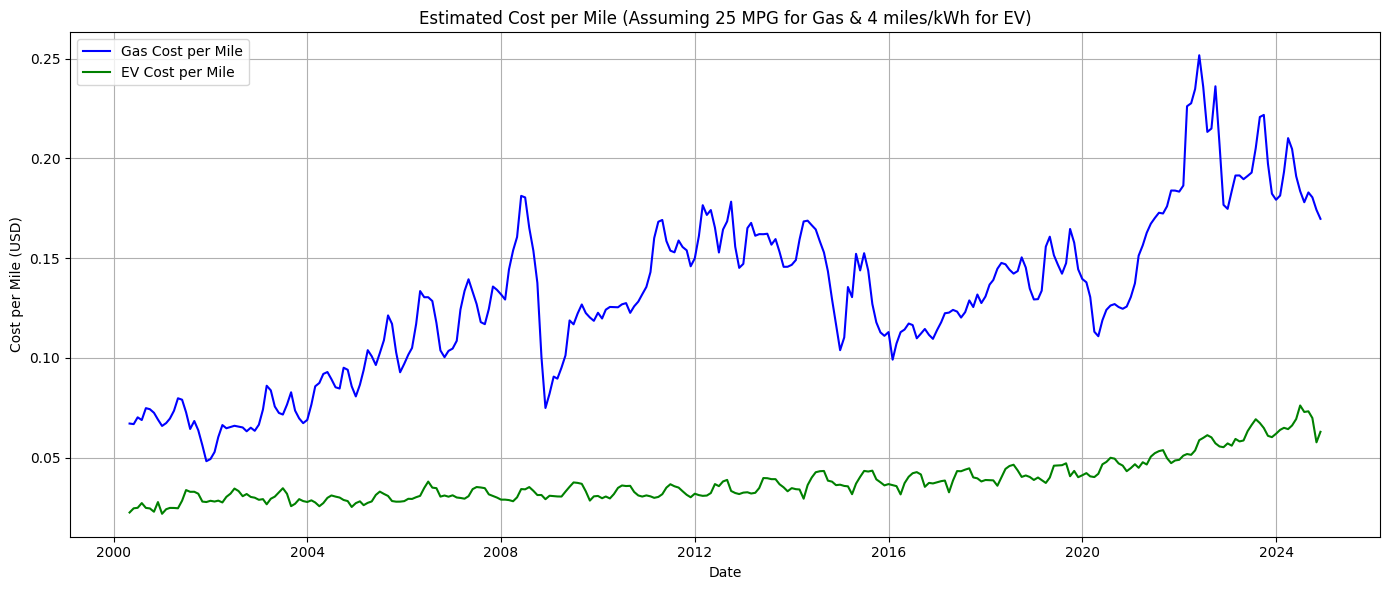

In [ ]:
# Cost per Mile (Assumptions) Calculations
# Assumed fuel efficiency and energy efficiency values:
gas_mpg = 25           # Average miles per gallon for a gas vehicle
ev_efficiency = 4      # Average miles per kWh for an electric vehicle

# Calculate estimated cost per mile:
# For gas: (dollars per gallon) / (miles per gallon) = dollars per mile
merged_df['Gas Cost per Mile'] = merged_df['Gas Price'] / gas_mpg

# For EV: (dollars per kWh) / (miles per kWh) = dollars per mile
merged_df['EV Cost per Mile'] = merged_df['Electric Rate'] / ev_efficiency

# Estimated Cost per Mile Plot
plt.figure(figsize=(14, 6))
plt.plot(merged_df['Date'], merged_df['Gas Cost per Mile'], label='Gas Cost per Mile', color='blue')
plt.plot(merged_df['Date'], merged_df['EV Cost per Mile'], label='EV Cost per Mile', color='green')
plt.title('Estimated Cost per Mile (Assuming 25 MPG for Gas & 4 miles/kWh for EV)')
plt.xlabel('Date')
plt.ylabel('Cost per Mile (USD)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

Merged DataFrame Columns: Index(['YearMonth', 'Gas Price', 'Electric Rate', 'Date', 'Gas Cost per Mile',
       'EV Cost per Mile', 'CPI'],
      dtype='object')
Merged DataFrame Preview:
  YearMonth    CPI
0   2000-05  171.2
1   2000-06  172.2
2   2000-07  172.7
3   2000-08  172.7
4   2000-09  173.6
NaN values in 'CPI' column: 0


<ipython-input-14-a9945a7922b5>:40: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  merged_df['CPI'] = merged_df['CPI'].fillna(method='ffill')


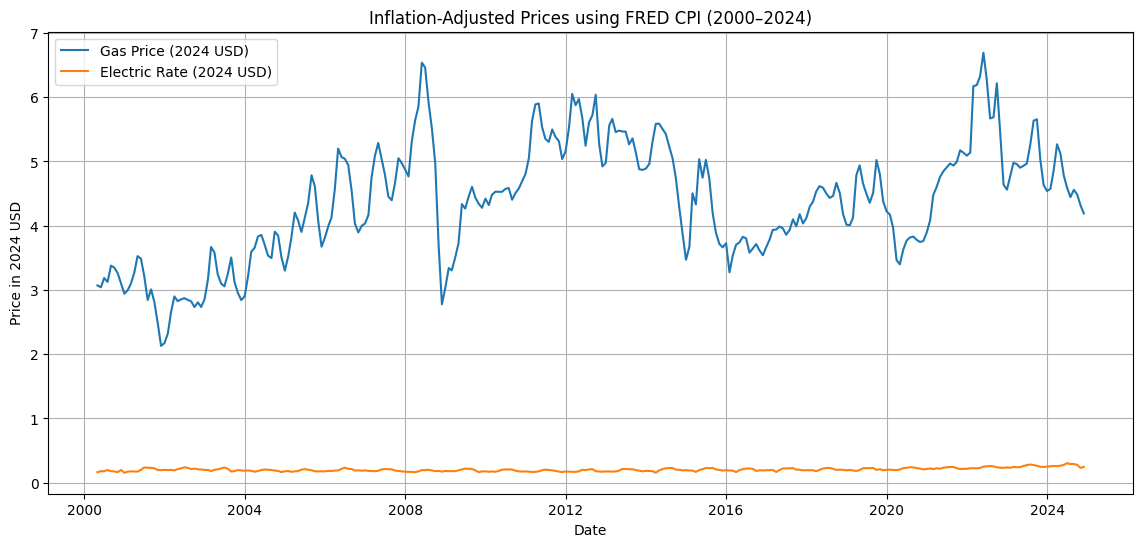

In [ ]:
# FRED API parameters
API_KEY = "29bb395c3bfdaed288ea9ae88029956d"
cpi_series_id = "CPIAUCSL"
api_url = f"https://api.stlouisfed.org/fred/series/observations?series_id={cpi_series_id}&api_key={API_KEY}&file_type=json"

response = requests.get(api_url)
cpi_data = response.json()['observations']

# CPI DataFrame
cpi_df = pd.DataFrame(cpi_data)
cpi_df['date'] = pd.to_datetime(cpi_df['date'])
cpi_df['value'] = pd.to_numeric(cpi_df['value'])
cpi_df = cpi_df[(cpi_df['date'] >= '2000-01-01') & (cpi_df['date'] <= '2024-12-31')]
cpi_df['YearMonth'] = cpi_df['date'].dt.to_period('M')

# CPI dictionary mapping year to CPI value
cpi_dict = cpi_df.groupby(cpi_df['date'].dt.year)['value'].mean().to_dict()

# Merge CPI into main dataframe
merged_df = pd.merge(merged_df, cpi_df[['YearMonth', 'value']], on='YearMonth', how='left')
merged_df = merged_df.rename(columns={'value': 'CPI'})

# Handle duplicate 'CPI' columns
merged_df = merged_df.loc[:, ~merged_df.columns.duplicated()]

print("Merged DataFrame Columns:", merged_df.columns)
print("Merged DataFrame Preview:")
print(merged_df[['YearMonth', 'CPI']].head())

merged_df['Gas Price'] = pd.to_numeric(merged_df['Gas Price'], errors='coerce')
merged_df['Electric Rate'] = pd.to_numeric(merged_df['Electric Rate'], errors='coerce')
print(f"NaN values in 'CPI' column: {merged_df['CPI'].isna().sum()}")

merged_df['CPI'] = merged_df['CPI'].fillna(method='ffill')

# Normalize CPI to 2024 average
base_cpi = cpi_df[cpi_df['date'].dt.year == 2024]['value'].mean()

# Calculate CPI Factor
merged_df['CPI Factor'] = base_cpi / merged_df['CPI']

# Calculate inflation-adjusted prices
merged_df['Gas Adj'] = merged_df['Gas Price'] * merged_df['CPI Factor']
merged_df['Elec Adj'] = merged_df['Electric Rate'] * merged_df['CPI Factor']

# Inflation-Adjusted Prices (FRED-based) Plot
plt.figure(figsize=(14, 6))
plt.plot(merged_df['Date'], merged_df['Gas Adj'], label='Gas Price (2024 USD)')
plt.plot(merged_df['Date'], merged_df['Elec Adj'], label='Electric Rate (2024 USD)')
plt.title('Inflation-Adjusted Prices using FRED CPI (2000–2024)')
plt.xlabel('Date')
plt.ylabel('Price in 2024 USD')
plt.legend()
plt.grid(True)
plt.show()

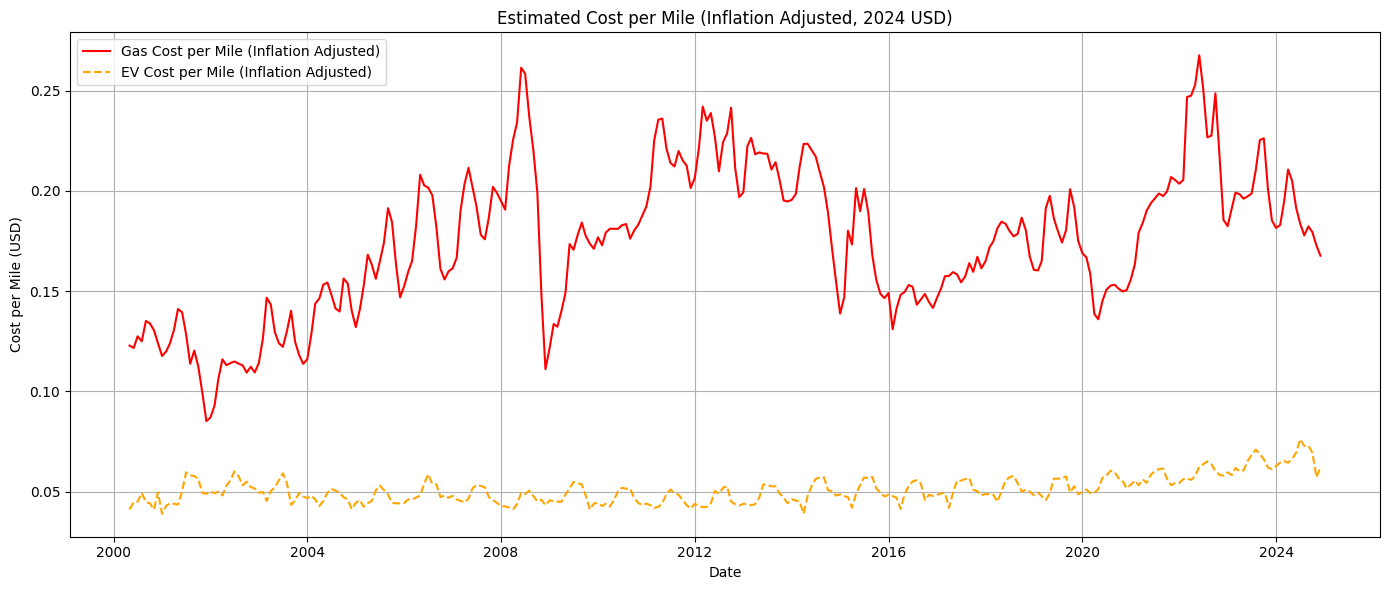

Gas Cost per Mile (Inflation Adjusted) Statistics:
count    296.000000
mean       0.174414
std        0.036356
min        0.085162
25%        0.148171
50%        0.177381
75%        0.199953
max        0.267652

EV Cost per Mile (Inflation Adjusted) Statistics:
count    296.000000
mean       0.050917
std        0.006788
min        0.038900
25%        0.045676
50%        0.049468
75%        0.055368
max        0.076132


In [ ]:
# Calculate Inflation-Adjusted Cost per Mile
# Assuming efficiency values:
gas_mpg = 25           # Average miles per gallon for a gas vehicle
ev_efficiency = 4      # Average miles per kWh for an EV

# Calculate cost per mile using the inflation-adjusted prices:
# Gas cost per mile (in 2024 USD)
merged_df['Gas Cost per Mile (Inflation Adjusted)'] = merged_df['Gas Adj'] / gas_mpg

# EV cost per mile (in 2024 USD)
merged_df['EV Cost per Mile (Inflation Adjusted)'] = merged_df['Elec Adj'] / ev_efficiency

# Plot the Inflation-Adjusted Cost per Mile
plt.figure(figsize=(14, 6))
plt.plot(merged_df['Date'],
         merged_df['Gas Cost per Mile (Inflation Adjusted)'],
         label='Gas Cost per Mile (Inflation Adjusted)', color='red')
plt.plot(merged_df['Date'],
         merged_df['EV Cost per Mile (Inflation Adjusted)'],
         label='EV Cost per Mile (Inflation Adjusted)', color='orange', linestyle='--')
plt.title('Estimated Cost per Mile (Inflation Adjusted, 2024 USD)')
plt.xlabel('Date')
plt.ylabel('Cost per Mile (USD)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Descriptive statistics for Gas Cost per Mile (Inflation Adjusted)
gas_cost_stats = merged_df['Gas Cost per Mile (Inflation Adjusted)'].describe()

# Descriptive statistics for EV Cost per Mile (Inflation Adjusted)
ev_cost_stats = merged_df['EV Cost per Mile (Inflation Adjusted)'].describe()

print("Gas Cost per Mile (Inflation Adjusted) Statistics:")
print(gas_cost_stats.to_string())

print("\nEV Cost per Mile (Inflation Adjusted) Statistics:")
print(ev_cost_stats.to_string())

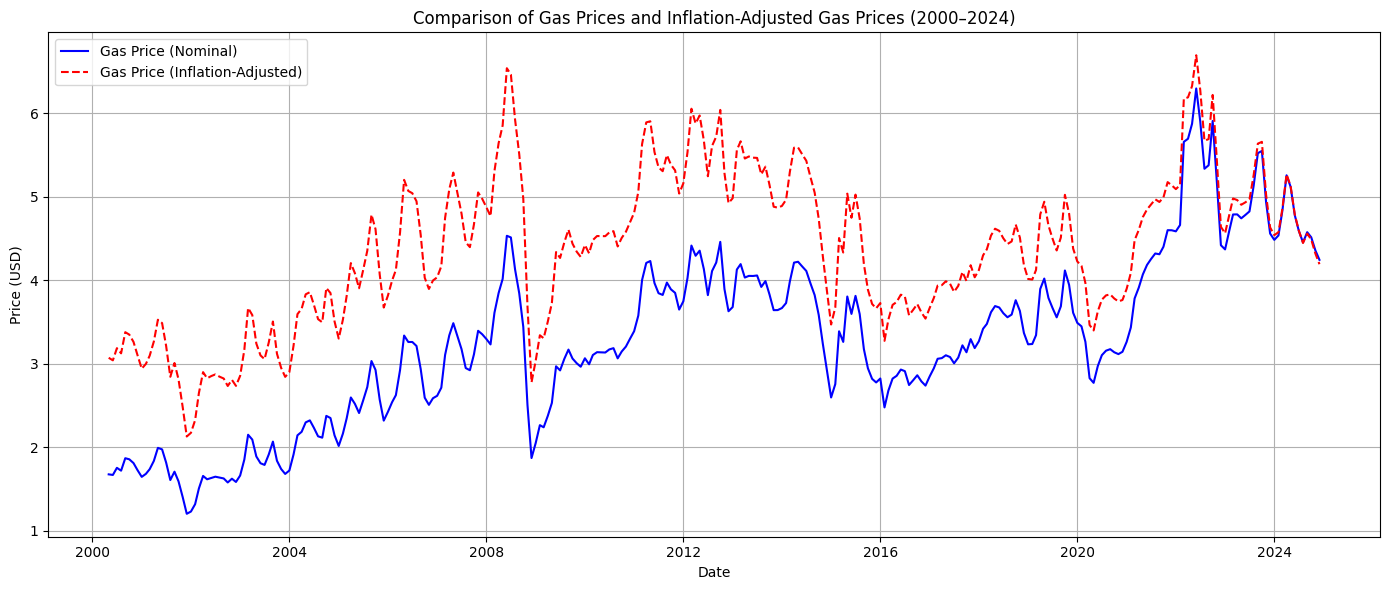

In [ ]:
# Gas Prices vs. Inflation-Adjusted Gas Prices
plt.figure(figsize=(14, 6))
plt.plot(merged_df['Date'], merged_df['Gas Price'], label='Gas Price (Nominal)', color='blue')
plt.plot(merged_df['Date'], merged_df['Gas Adj'], label='Gas Price (Inflation-Adjusted)', color='red', linestyle='--')
plt.title('Comparison of Gas Prices and Inflation-Adjusted Gas Prices (2000–2024)')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

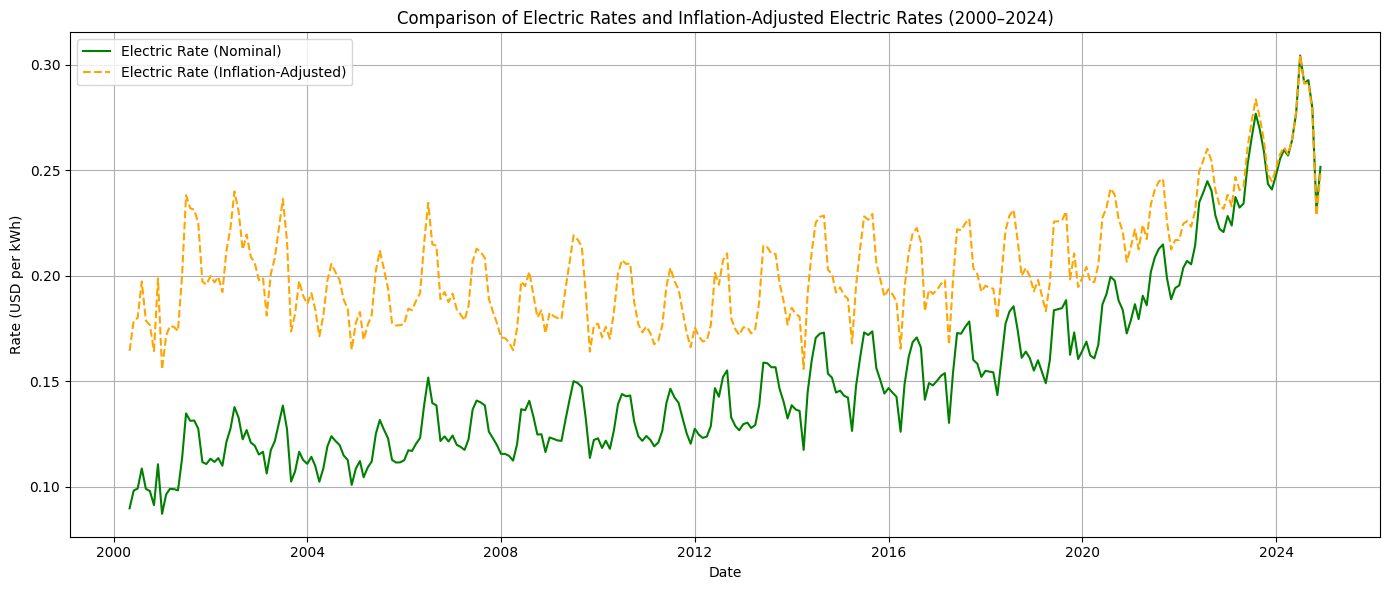

In [ ]:
# Electric Rates vs. Inflation-Adjusted Electric Rates
plt.figure(figsize=(14, 6))
plt.plot(merged_df['Date'], merged_df['Electric Rate'], label='Electric Rate (Nominal)', color='green')
plt.plot(merged_df['Date'], merged_df['Elec Adj'], label='Electric Rate (Inflation-Adjusted)', color='orange', linestyle='--')
plt.title('Comparison of Electric Rates and Inflation-Adjusted Electric Rates (2000–2024)')
plt.xlabel('Date')
plt.ylabel('Rate (USD per kWh)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

Correlation between gas and electric prices: 0.731


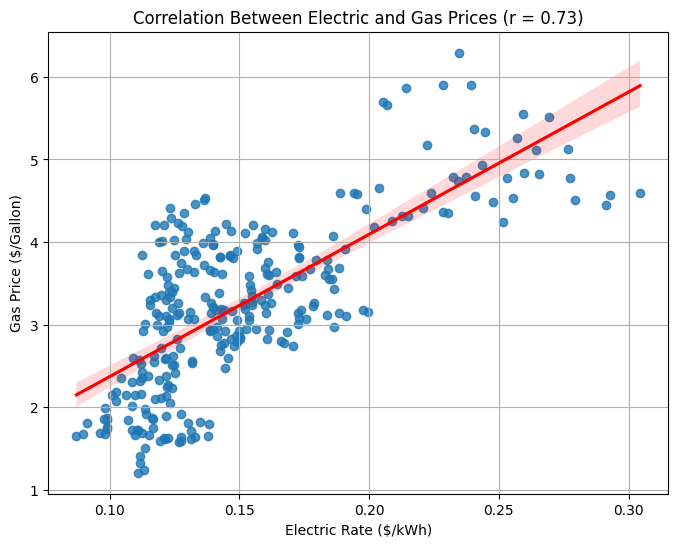

In [ ]:
# Correlation Analysis
correlation = merged_df[['Gas Price', 'Electric Rate']].corr().iloc[0, 1]
print(f"Correlation between gas and electric prices: {correlation:.3f}")

# Correlation Graph
plt.figure(figsize=(8, 6))
sns.regplot(data=merged_df, x='Electric Rate', y='Gas Price', line_kws={"color": "red"})
plt.title(f'Correlation Between Electric and Gas Prices (r = {correlation:.2f})')
plt.xlabel('Electric Rate ($/kWh)')
plt.ylabel('Gas Price ($/Gallon)')
plt.grid(True)
plt.show()

A correlation of approximately 0.73 indicates a moderately strong positive relationship between electric rates and gas prices. In practical terms, this means that when electric rates go up, gas prices also tend to go up (and vice versa).

Correlation ≠ Causation. A positive correlation does not necessarily mean that rising electric rates cause higher gas prices. It just indicates that they tend to move in the same direction over time. Both could be influenced by a common factor such as overall inflation, energy market trends, or other macroeconomic conditions.

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpzp1asuvc/ih6yx3az.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpzp1asuvc/2oh90ami.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=49362', 'data', 'file=/tmp/tmpzp1asuvc/ih6yx3az.json', 'init=/tmp/tmpzp1asuvc/2oh90ami.json', 'output', 'file=/tmp/tmpzp1asuvc/prophet_modelb85bk2u5/prophet_model-20250415021953.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
02:19:53 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
02:19:53 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
/usr/local/lib/python3.11/dist-packages/

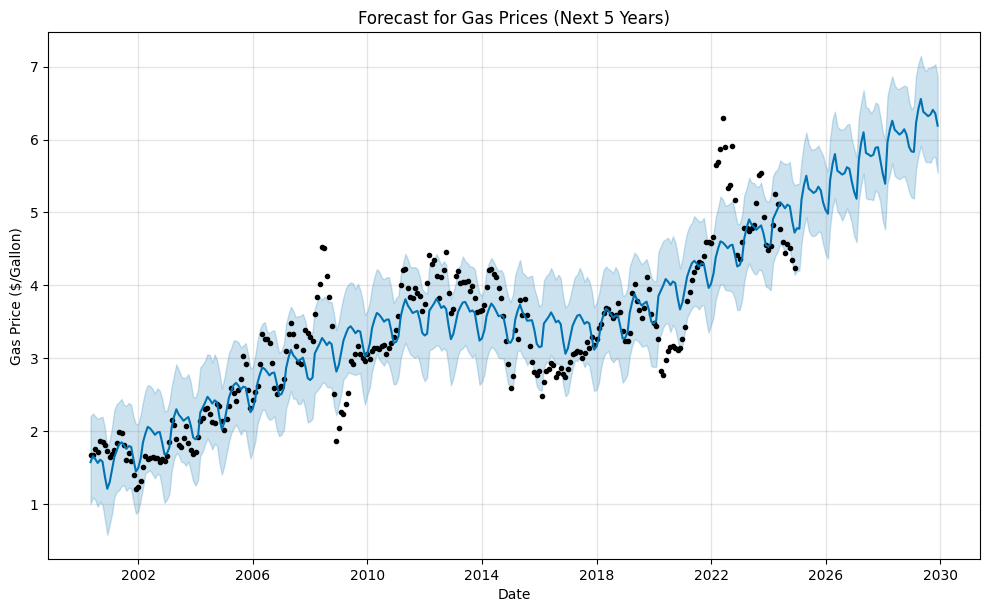

In [ ]:
!pip install prophet

from prophet import Prophet

gas_prophet_df = gas_df[['Date', 'Gas Price']].copy()
gas_prophet_df.columns = ['ds', 'y']

model_gas = Prophet()
model_gas.fit(gas_prophet_df)

# Dataframe to hold predictions for the next 60 months (5 years)
future_gas = model_gas.make_future_dataframe(periods=60, freq='M')
forecast_gas = model_gas.predict(future_gas)

# Plot the forecast
fig_gas = model_gas.plot(forecast_gas)
plt.title("Forecast for Gas Prices (Next 5 Years)")
plt.xlabel("Date")
plt.ylabel("Gas Price ($/Gallon)")
plt.show()

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpzp1asuvc/_pekhp5q.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpzp1asuvc/2gabcxv9.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=91915', 'data', 'file=/tmp/tmpzp1asuvc/_pekhp5q.json', 'init=/tmp/tmpzp1asuvc/2gabcxv9.json', 'output', 'file=/tmp/tmpzp1asuvc/prophet_model2dxteupe/prophet_model-20250415021954.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
02:19:54 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
02:19:54 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
/usr/local/lib/python3.11/dist-packages/

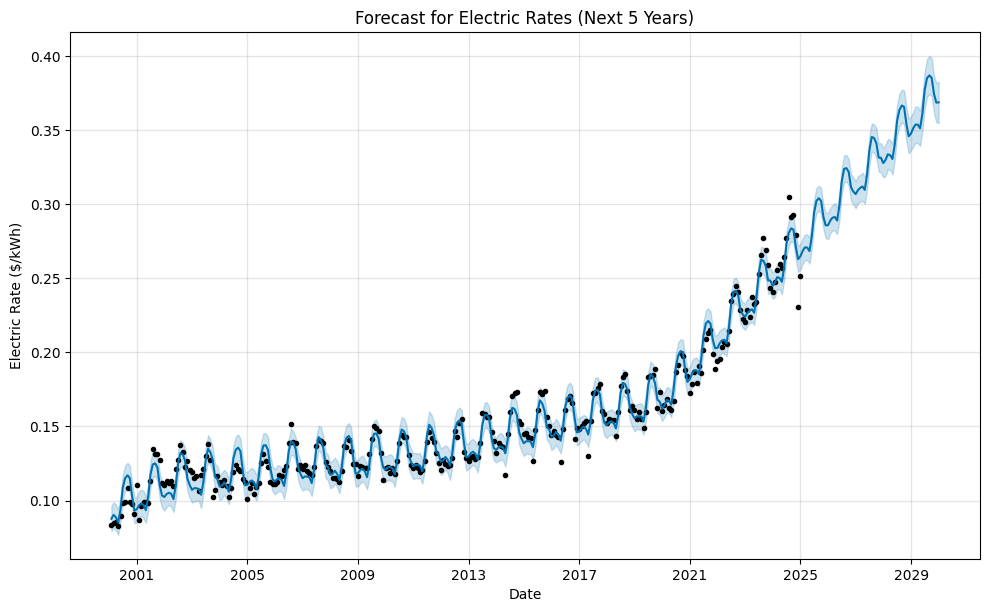

In [ ]:
# Electric rates data for Prophet forecasting
elec_prophet_df = elec_df[['Date', 'Electric Rate']].copy()
elec_prophet_df.columns = ['ds', 'y']

model_elec = Prophet()
model_elec.fit(elec_prophet_df)

# Dataframe for predictions for the next 60 months
future_elec = model_elec.make_future_dataframe(periods=60, freq='M')
forecast_elec = model_elec.predict(future_elec)

# Plot the forecast
fig_elec = model_elec.plot(forecast_elec)
plt.title("Forecast for Electric Rates (Next 5 Years)")
plt.xlabel("Date")
plt.ylabel("Electric Rate ($/kWh)")
plt.show()

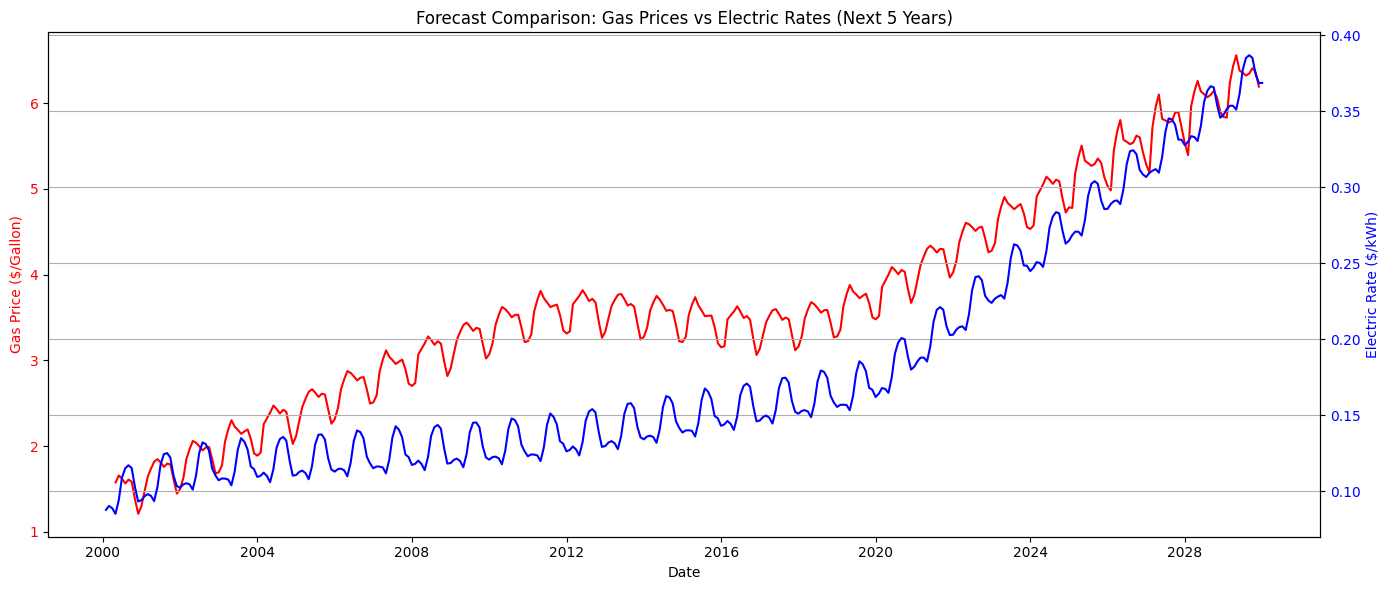

In [ ]:
import matplotlib.pyplot as plt

fig, ax1 = plt.subplots(figsize=(14, 6))

# Plot Gas Price forecast
ax1.plot(forecast_gas['ds'], forecast_gas['yhat'], label='Gas Price Forecast', color='red')
ax1.set_xlabel('Date')
ax1.set_ylabel('Gas Price ($/Gallon)', color='red')
ax1.tick_params(axis='y', labelcolor='red')

ax2 = ax1.twinx()
ax2.plot(forecast_elec['ds'], forecast_elec['yhat'], label='Electric Rate Forecast', color='blue')
ax2.set_ylabel('Electric Rate ($/kWh)', color='blue')
ax2.tick_params(axis='y', labelcolor='blue')

plt.title('Forecast Comparison: Gas Prices vs Electric Rates (Next 5 Years)')
fig.tight_layout()
plt.grid(True)
plt.show()

In [ ]:
gas_prophet_df = gas_df[['Date', 'Gas Price']].copy()
gas_prophet_df.columns = ['ds', 'y']

elec_prophet_df = elec_df[['Date', 'Electric Rate']].copy()
elec_prophet_df.columns = ['ds', 'y']

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpzp1asuvc/u9r9hhwx.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpzp1asuvc/apj1l_lt.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=6851', 'data', 'file=/tmp/tmpzp1asuvc/u9r9hhwx.json', 'init=/tmp/tmpzp1asuvc/apj1l_lt.json', 'output', 'file=/tmp/tmpzp1asuvc/prophet_modelnt4riobr/prophet_model-20250415021955.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
02:19:55 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
02:19:55 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
/usr/local/lib/python3.11/dist-packages/p

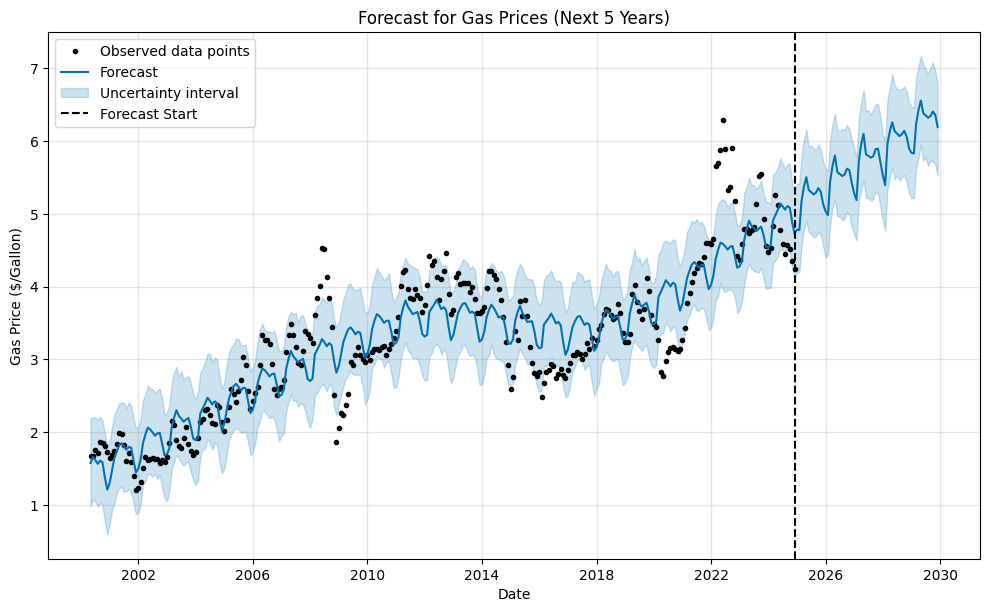

In [ ]:
from prophet import Prophet
import matplotlib.pyplot as plt

model_gas = Prophet()
model_gas.fit(gas_prophet_df)
future_gas = model_gas.make_future_dataframe(periods=60, freq='M')
forecast_gas = model_gas.predict(future_gas)

# Determine the cutoff date from the training data (last historical date)
cutoff_date_gas = gas_prophet_df['ds'].max()

# Plot the forecast for gas prices and add the cutoff line
fig_gas = model_gas.plot(forecast_gas)
plt.axvline(x=cutoff_date_gas, color='black', linestyle='--', label='Forecast Start')
plt.title("Forecast for Gas Prices (Next 5 Years)")
plt.xlabel("Date")
plt.ylabel("Gas Price ($/Gallon)")
plt.legend()
plt.show()

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpzp1asuvc/g98d8yf7.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpzp1asuvc/q8vvieyq.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=93830', 'data', 'file=/tmp/tmpzp1asuvc/g98d8yf7.json', 'init=/tmp/tmpzp1asuvc/q8vvieyq.json', 'output', 'file=/tmp/tmpzp1asuvc/prophet_model7kkr6499/prophet_model-20250415021955.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
02:19:55 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
02:19:56 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
/usr/local/lib/python3.11/dist-packages/

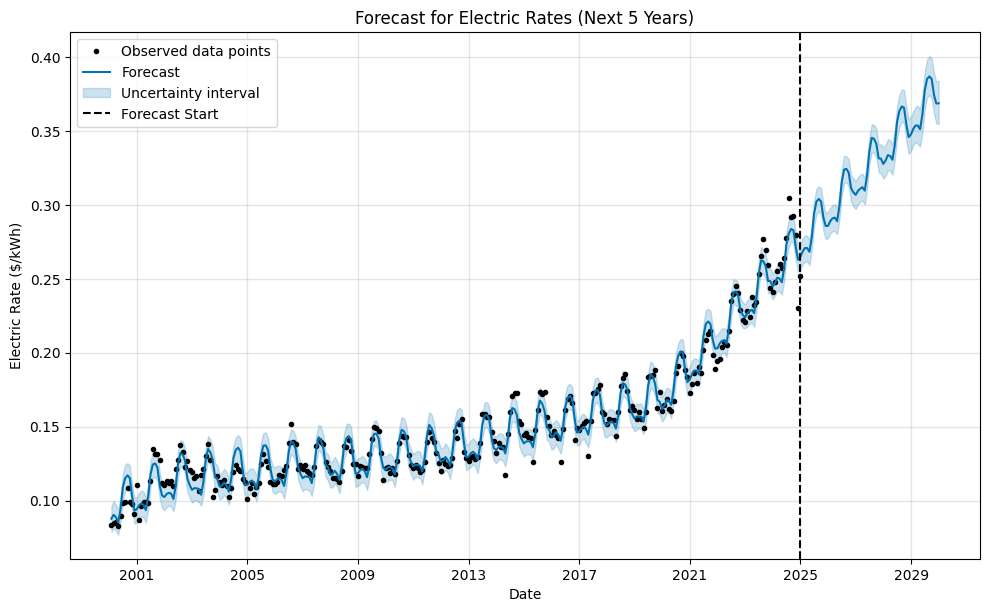

In [ ]:
# Fit the electric model and forecast
model_elec = Prophet()
model_elec.fit(elec_prophet_df)
future_elec = model_elec.make_future_dataframe(periods=60, freq='M')
forecast_elec = model_elec.predict(future_elec)

# Determine the cutoff date from the training data (last historical date)
cutoff_date_elec = elec_prophet_df['ds'].max()

# Plot the forecast for electric rates and add the cutoff line
fig_elec = model_elec.plot(forecast_elec)
plt.axvline(x=cutoff_date_elec, color='black', linestyle='--', label='Forecast Start')
plt.title("Forecast for Electric Rates (Next 5 Years)")
plt.xlabel("Date")
plt.ylabel("Electric Rate ($/kWh)")
plt.legend()
plt.show()

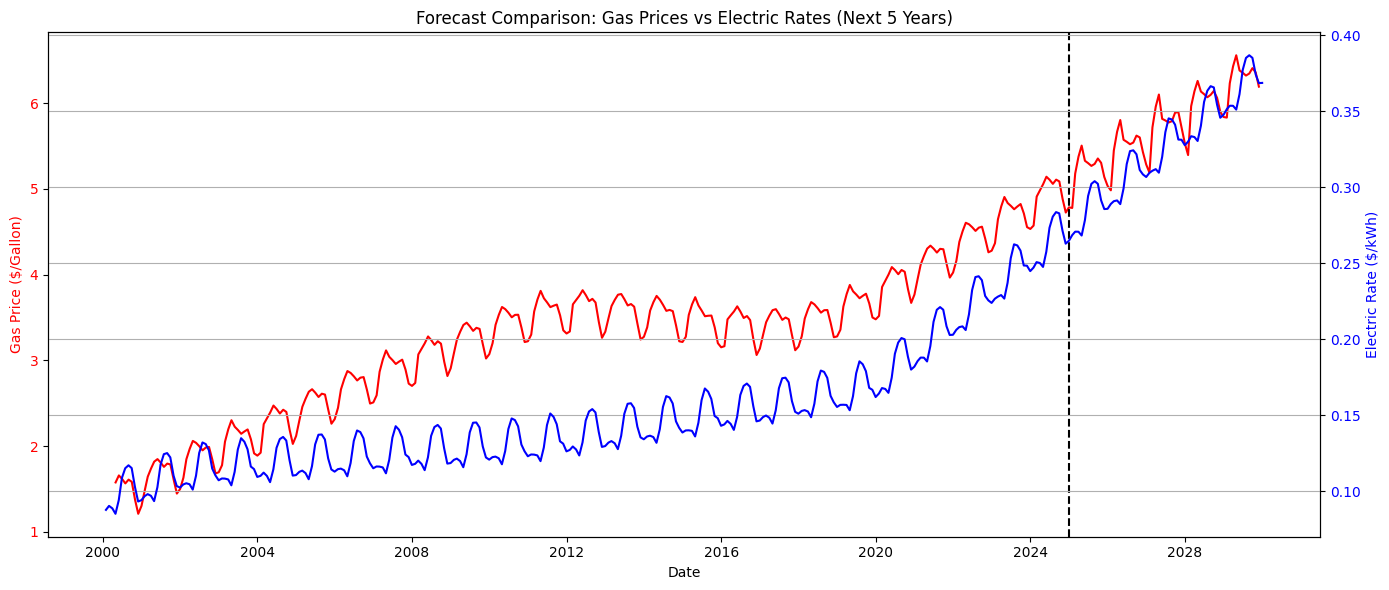

Gas Price Forecast (Monthly Predictions):
        ds     yhat  yhat_lower  yhat_upper
2024-12-31 4.784024    4.188305    5.406123
2025-01-31 4.776948    4.192562    5.420748
2025-02-28 5.177807    4.570106    5.805814
2025-03-31 5.374262    4.788560    6.015121
2025-04-30 5.503829    4.908474    6.166818
2025-05-31 5.326925    4.753242    5.916987
2025-06-30 5.299546    4.714971    5.942251
2025-07-31 5.267226    4.679340    5.900563
2025-08-31 5.290465    4.693255    5.873159
2025-09-30 5.353528    4.743393    5.957502
2025-10-31 5.303189    4.718628    5.885950
2025-11-30 5.137722    4.557126    5.722261
2025-12-31 5.034550    4.396972    5.622358
2026-01-31 4.982447    4.439187    5.593804
2026-02-28 5.446199    4.843943    6.025661
2026-03-31 5.665126    5.087526    6.237399
2026-04-30 5.802177    5.188019    6.374992
2026-05-31 5.571899    4.969547    6.149425
2026-06-30 5.548449    4.964358    6.138130
2026-07-31 5.520114    4.916311    6.167452
2026-08-31 5.539275    4.935112   

In [ ]:
# Determine a common cutoff date (latest historical date among both datasets)
cutoff_date = max(gas_prophet_df['ds'].max(), elec_prophet_df['ds'].max())

# Create a figure and first axis for gas prices forecast
fig, ax1 = plt.subplots(figsize=(14, 6))

# Plot Gas Price forecast on ax1
ax1.plot(forecast_gas['ds'], forecast_gas['yhat'], label='Gas Price Forecast', color='red')
ax1.set_xlabel('Date')
ax1.set_ylabel('Gas Price ($/Gallon)', color='red')
ax1.tick_params(axis='y', labelcolor='red')

ax1.axvline(x=cutoff_date, color='black', linestyle='--', label='Forecast Start')

# Create a second axis for electric rate forecast, sharing the same x-axis
ax2 = ax1.twinx()
ax2.plot(forecast_elec['ds'], forecast_elec['yhat'], label='Electric Rate Forecast', color='blue')
ax2.set_ylabel('Electric Rate ($/kWh)', color='blue')
ax2.tick_params(axis='y', labelcolor='blue')

plt.title('Forecast Comparison: Gas Prices vs Electric Rates (Next 5 Years)')
fig.tight_layout()
plt.grid(True)
plt.show()

# Extract predictions starting from the cutoff date for both forecasts
predicted_gas = forecast_gas[forecast_gas['ds'] >= cutoff_date]
predicted_elec = forecast_elec[forecast_elec['ds'] >= cutoff_date]

# Print the forecasts for Gas Prices
print("Gas Price Forecast (Monthly Predictions):")
print(predicted_gas[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].to_string(index=False))

# Print the forecasts for Electric Rates
print("\nElectric Rate Forecast (Monthly Predictions):")
print(predicted_elec[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].to_string(index=False))


        Date  Gas Price  Gas Rate Change (%)  Electric Rate  \
0 2000-05-01      1.676                  NaN         0.0897   
1 2000-06-01      1.669            -0.417661         0.0981   
2 2000-07-01      1.754             5.092870         0.0991   
3 2000-08-01      1.720            -1.938426         0.1086   
4 2000-09-01      1.869             8.662791         0.0989   

   Electric Rate Change (%)  
0                       NaN  
1                  9.364548  
2                  1.019368  
3                  9.586276  
4                 -8.931860  
Average monthly percentage change in Gas Price: 0.54%
Average monthly percentage change in Electric Rate: 0.57%


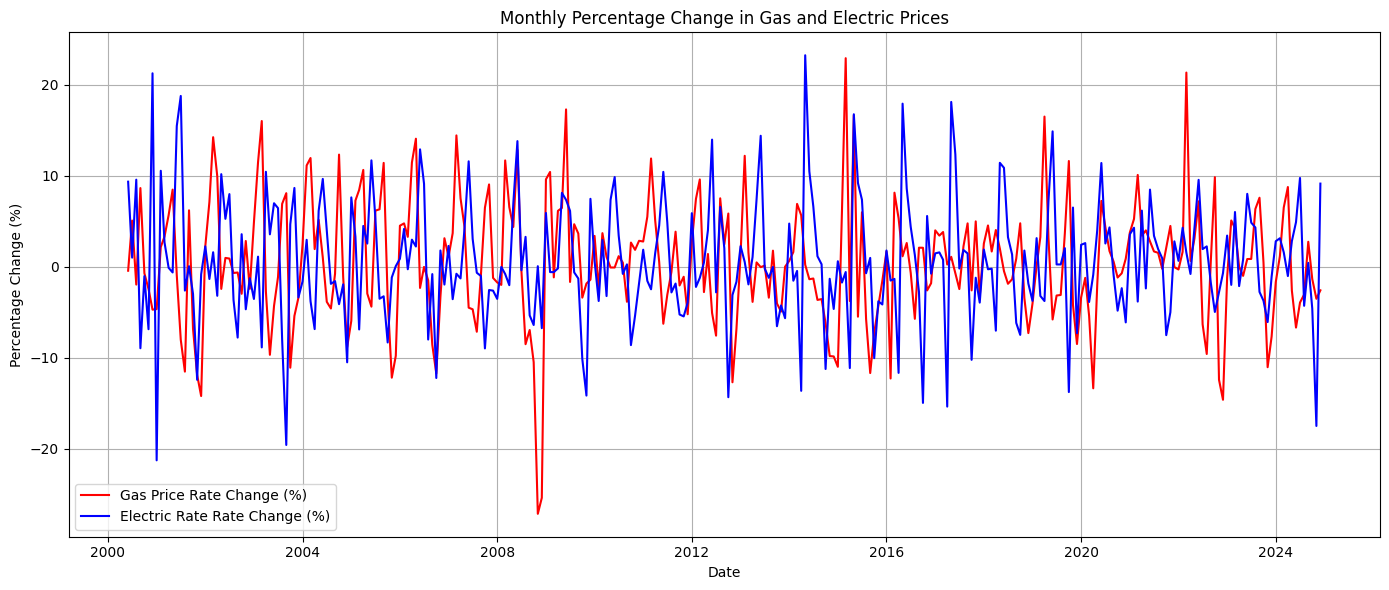

Pearson's correlation coefficient between the rate of change in gas and electric prices: 0.028


In [ ]:
# Calculate the monthly percentage change for Gas Price and Electric Rate
merged_df['Gas Rate Change (%)'] = merged_df['Gas Price'].pct_change() * 100
merged_df['Electric Rate Change (%)'] = merged_df['Electric Rate'].pct_change() * 100

print(merged_df[['Date', 'Gas Price', 'Gas Rate Change (%)',
                 'Electric Rate', 'Electric Rate Change (%)']].head())

# Calculate and print the average monthly percentage change for each
mean_gas_change = merged_df['Gas Rate Change (%)'].mean()
mean_elec_change = merged_df['Electric Rate Change (%)'].mean()
print("Average monthly percentage change in Gas Price: {:.2f}%".format(mean_gas_change))
print("Average monthly percentage change in Electric Rate: {:.2f}%".format(mean_elec_change))

# Plotting the Rate of Change Over Time
plt.figure(figsize=(14, 6))
plt.plot(merged_df['Date'], merged_df['Gas Rate Change (%)'],
         label='Gas Price Rate Change (%)', color='red')
plt.plot(merged_df['Date'], merged_df['Electric Rate Change (%)'],
         label='Electric Rate Rate Change (%)', color='blue')
plt.title("Monthly Percentage Change in Gas and Electric Prices")
plt.xlabel("Date")
plt.ylabel("Percentage Change (%)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Calculate Pearson's Correlation Coefficient Between the Rates of Change
rate_changes = merged_df[['Gas Rate Change (%)', 'Electric Rate Change (%)']].dropna()

# Calculate the Pearson correlation coefficient
corr_coefficient = rate_changes['Gas Rate Change (%)'].corr(rate_changes['Electric Rate Change (%)'])
print("Pearson's correlation coefficient between the rate of change in gas and electric prices: {:.3f}".format(corr_coefficient))

DEBUG:cmdstanpy:input tempfile: /tmp/tmpet0t29he/n3t7uahd.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpet0t29he/bauyulx6.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=35534', 'data', 'file=/tmp/tmpet0t29he/n3t7uahd.json', 'init=/tmp/tmpet0t29he/bauyulx6.json', 'output', 'file=/tmp/tmpet0t29he/prophet_modelat9d60uv/prophet_model-20250429180251.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:02:51 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:02:51 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
/usr/local/lib/python3.11/dist-packages/prophet/forecaster.py:1854: FutureWarning:

'M' is deprecated and will be removed in a future version, please use 'ME' instead.



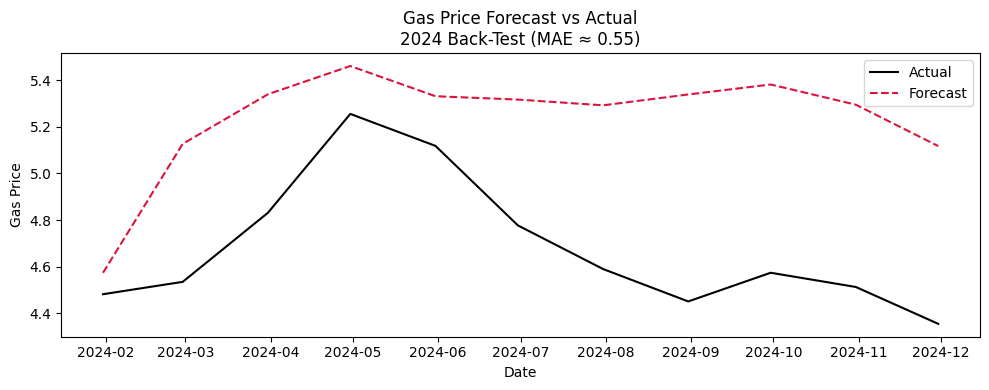

DEBUG:cmdstanpy:input tempfile: /tmp/tmpet0t29he/7jvnoqc6.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpet0t29he/ixj3ce2x.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=33629', 'data', 'file=/tmp/tmpet0t29he/7jvnoqc6.json', 'init=/tmp/tmpet0t29he/ixj3ce2x.json', 'output', 'file=/tmp/tmpet0t29he/prophet_modelsexskv_m/prophet_model-20250429180252.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:02:52 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:02:52 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
/usr/local/lib/python3.11/dist-packages/prophet/forecaster.py:1854: FutureWarning:

'M' is deprecated and will be removed in a future version, please use 'ME' instead.



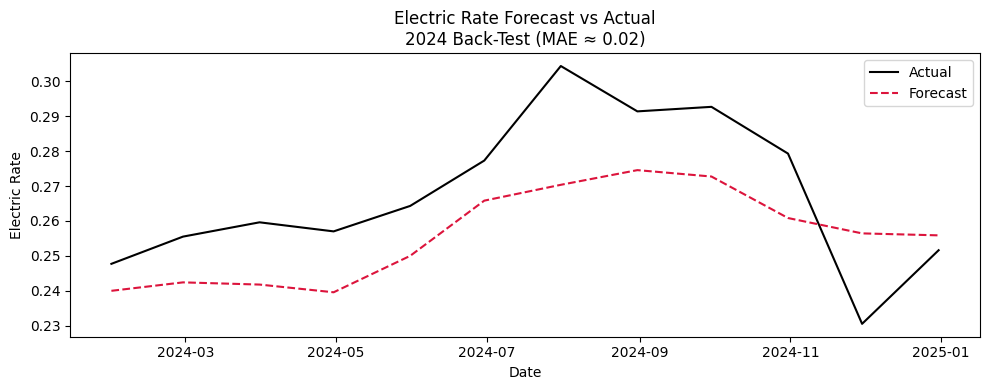

In [ ]:
!pip install prophet --quiet

import pandas as pd
import matplotlib.pyplot as plt
from prophet import Prophet
from sklearn.metrics import mean_absolute_error

# Helper to back‐test and plot statically
def backtest_and_plot(df, date_col, value_col, title):
    train = df[df[date_col] < '2024-01-01']
    test  = df[df[date_col] >= '2024-01-01']

    m = Prophet(yearly_seasonality=True,
                weekly_seasonality=False,
                daily_seasonality=False)
    m.fit(train[[date_col, value_col]]
          .rename(columns={date_col:'ds', value_col:'y'}))

    future = m.make_future_dataframe(periods=len(test), freq='M')
    fcst   = m.predict(future)[['ds','yhat']].copy()

    fcst['YearMonth'] = fcst['ds'].dt.to_period('M')
    fcst.index        = fcst['YearMonth'].dt.to_timestamp('M')
    actual = (test
              .set_index(date_col)[value_col]
              .to_frame('actual'))
    actual.index = actual.index.to_period('M').to_timestamp('M')

    cmp = actual.join(fcst[['yhat']], how='inner')
    mae = mean_absolute_error(cmp['actual'], cmp['yhat'])

    plt.figure(figsize=(10, 4))
    plt.plot(cmp.index, cmp['actual'], label='Actual', color='black')
    plt.plot(cmp.index, cmp['yhat'],   label='Forecast', color='crimson', linestyle='--')
    plt.title(f"{title}\n2024 Back‐Test (MAE ≈ {mae:.2f})")
    plt.xlabel("Date")
    plt.ylabel(value_col)
    plt.legend()
    plt.tight_layout()
    plt.show()

gas_path  = '/content/drive/MyDrive/Project CS163 Datasets/Monthly Gas Prices.csv'
elec_path = '/content/drive/MyDrive/Project CS163 Datasets/California Electric Rates.csv'

gas_df = pd.read_csv(gas_path, skiprows=2, usecols=[0,1])
gas_df.columns = ['Date','Gas Price']
gas_df = gas_df[gas_df['Date']!='Date'].dropna(subset=['Date'])
gas_df['Date'] = pd.to_datetime(gas_df['Date'], format='%b-%Y', errors='coerce')
gas_df = gas_df.dropna(subset=['Date'])
gas_df = gas_df[(gas_df['Date'].dt.year>=2000)&(gas_df['Date'].dt.year<=2024)]
gas_df['YearMonth'] = gas_df['Date'].dt.to_period('M')

elec_df = pd.read_csv(elec_path)
if 'YearMonth' in elec_df.columns:
    elec_df = elec_df.drop(columns=['YearMonth'])
elec_df['Date'] = pd.to_datetime(elec_df['Date'], errors='coerce')
elec_df = elec_df.dropna(subset=['Date'])
elec_df = elec_df[(elec_df['Date'].dt.year>=2000)&(elec_df['Date'].dt.year<=2024)]
elec_df['YearMonth'] = elec_df['Date'].dt.to_period('M')

for col in elec_df.columns:
    if 'USD/kWh' in col or 'Value' in col:
        elec_df = elec_df.rename(columns={col:'Electric Rate'})

backtest_and_plot(
    gas_df,  'Date', 'Gas Price',
    "Gas Price Forecast vs Actual"
)
backtest_and_plot(
    elec_df, 'Date', 'Electric Rate',
    "Electric Rate Forecast vs Actual"
)